In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

plt.style.use('seaborn')

/var/folders/xh/4c67ndhd4rggdt_j_x4syjgw0000gn/T/ipykernel_4199/4003140805.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In this section, we load the RECS (Residential Energy Consumption Survey) dataset and remove columns associated with the "End-use Model" to avoid using derived features from other models.

In [42]:
recs_codebook_df = pd.read_csv('recs2020_codebook.csv', header=1)
print("Codebook loaded successfully.")

recs_df = pd.read_csv('recs2020_data.csv')
print("Data loaded successfully.")

# # Remove columns associated with 'End-use Model' to avoid derived features
# cols_to_remove = recs_codebook_df[recs_codebook_df['Section'] == 'End-use Model'].Variable.unique().tolist()
# more_cols_to_keep = [col for col in recs_data.columns if col not in cols_to_remove]

# # Subset the dataframe to remove unnecessary columns
# big_subset_df = recs_data[more_cols_to_keep]

Codebook loaded successfully.
Data loaded successfully.


In [43]:
# Select columns where 'Include' is 'y'
cols_to_keep = recs_codebook_df[recs_codebook_df['Include'] == 'y']['Variable'].tolist()

# Select columns marked as 'outlier' to handle them separately
cols_to_fix = recs_codebook_df[recs_codebook_df['Include'] == 'outlier']['Variable'].tolist()

# Create a subset of the dataframe with selected columns
df_y = recs_df[cols_to_keep]
df_f = recs_df[cols_to_fix]

print(f"Selected {len(cols_to_keep)} features for analysis.")

# Handle outliers in the 'df_f' dataframe
# Replace specific values as per your team's approach
df_f[['LGTINLED', 'LGTINCFL', 'LGTINCAN']] = df_f[['LGTINLED', 'LGTINCFL', 'LGTINCAN']].replace(0, 5)
df_f[df_f < 0] = np.nan
df_f.replace(99, np.nan, inplace=True)

# Combine the cleaned 'outlier' columns with the main dataframe
subset_df = df_y.join(df_f)
print(f"The dataset now has {subset_df.shape[0]} rows and {subset_df.shape[1]} columns after combining.")


Selected 49 features for analysis.
The dataset now has 18496 rows and 117 columns after combining.


/var/folders/xh/4c67ndhd4rggdt_j_x4syjgw0000gn/T/ipykernel_4199/996396400.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f[['LGTINLED', 'LGTINCFL', 'LGTINCAN']] = df_f[['LGTINLED', 'LGTINCFL', 'LGTINCAN']].replace(0, 5)
/var/folders/xh/4c67ndhd4rggdt_j_x4syjgw0000gn/T/ipykernel_4199/996396400.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f[df_f < 0] = np.nan
/var/folders/xh/4c67ndhd4rggdt_j_x4syjgw0000gn/T/ipykernel_4199/996396400.py:16: SettingWithCopyWarning: 
A value is trying to be se

In [44]:
# Calculate the number of non-missing values in each column
number_values = subset_df.count()

# Identify columns with more than 25% missing data
threshold = 0.75 * len(subset_df)
cols_to_drop = [col for col in subset_df.columns if subset_df[col].count() < threshold]

# Drop columns with too many missing values
subset_df = subset_df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns due to excessive missing data.")

# Recalculate the number of missing values
missing_percentage = subset_df.isnull().mean() * 100
print(f"Remaining missing data percentage: {missing_percentage.mean():.2f}%")

# Check the number of features with missing data
num_missing_cols = subset_df.columns[subset_df.isnull().any()].tolist()
print(f"There are {len(num_missing_cols)} features with missing data remaining.")


Dropped 37 columns due to excessive missing data.
Remaining missing data percentage: 4.81%
There are 29 features with missing data remaining.


In [45]:
# Separate numerical and categorical columns
numerical_cols = subset_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = subset_df.select_dtypes(include=['object']).columns.tolist()

# Impute numerical columns with mean
num_imputer = SimpleImputer(strategy='mean')
subset_df[numerical_cols] = num_imputer.fit_transform(subset_df[numerical_cols])

# Impute categorical columns with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
subset_df[categorical_cols] = cat_imputer.fit_transform(subset_df[categorical_cols])

print("Imputation completed for missing values.")


Imputation completed for missing values.


In [46]:
# Normalize numerical columns using Min-Max scaling
scaler = MinMaxScaler()
subset_df[numerical_cols] = scaler.fit_transform(subset_df[numerical_cols])

print("Normalization of numerical data completed.")

Normalization of numerical data completed.


In [47]:
# One-hot encode categorical variables
subset_df = pd.get_dummies(subset_df, columns=categorical_cols, drop_first=True)
print(f"The dataset now has {subset_df.shape[1]} columns after one-hot encoding.")


The dataset now has 138 columns after one-hot encoding.


In [48]:
# Perform PCA to capture 90% of the variance
pca = PCA(n_components=0.90, random_state=42)
pca_result = pca.fit_transform(subset_df)

print(f"PCA reduced the dataset to {pca_result.shape[1]} principal components.")


PCA reduced the dataset to 61 principal components.


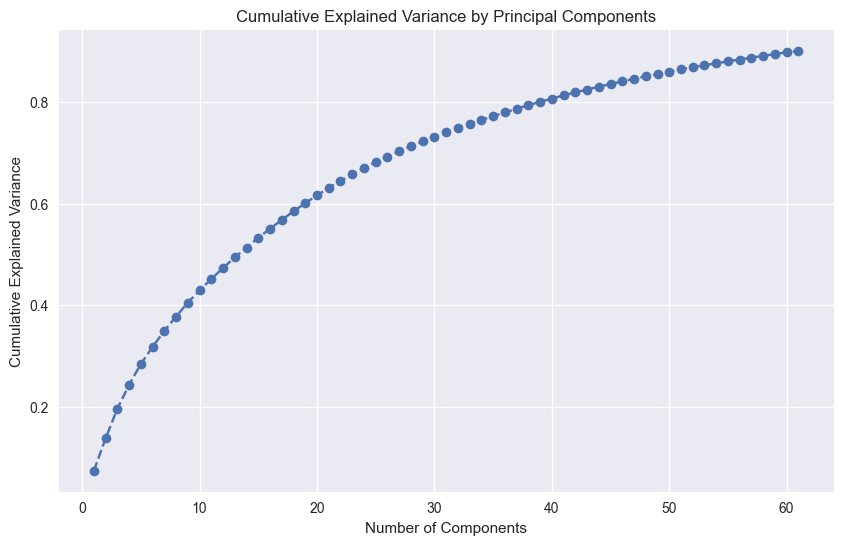

Number of components explaining at least 90% variance: 61


In [49]:
# Plot cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Determine the number of components that explain at least 90% of the variance
components_90_variance = np.argmax(explained_variance >= 0.90) + 1
print(f"Number of components explaining at least 90% variance: {components_90_variance}")

pca_90 = PCA(n_components=components_90_variance)
pca_90_result = pca_90.fit_transform(subset_df)

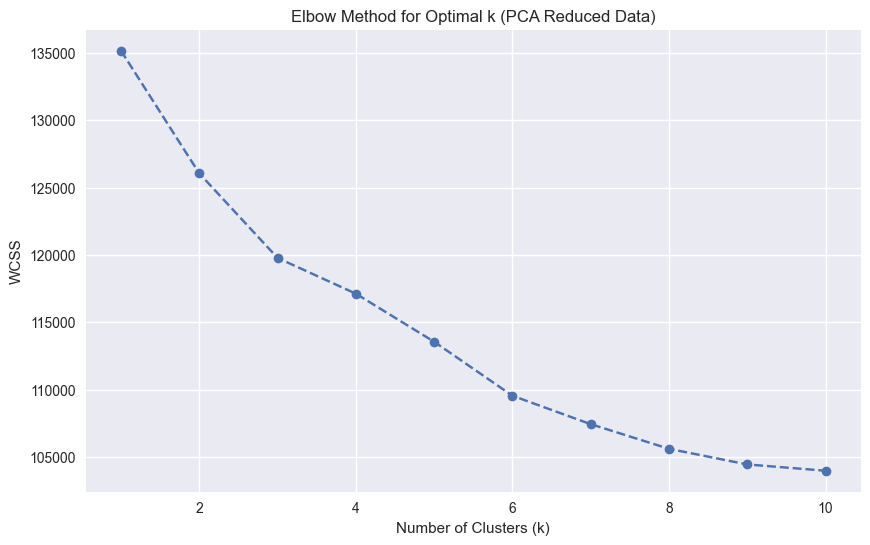

In [50]:
# Calculate WCSS (within-cluster sum of squares) for different values of k
wcss = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_90_result)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (PCA Reduced Data)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

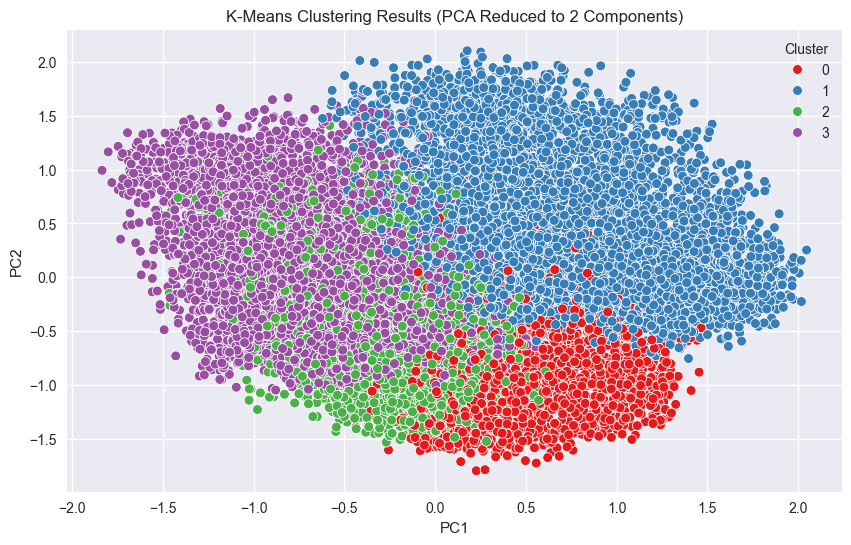

In [51]:
# Perform K-means clustering with the chosen k (4)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_90_result)

# Reduce to 2 components for visualization
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(pca_90_result)

# Create a dataframe for the 2D PCA results
pca_df = pd.DataFrame(data=pca_2_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=50)
plt.title('K-Means Clustering Results (PCA Reduced to 2 Components)')
plt.show()

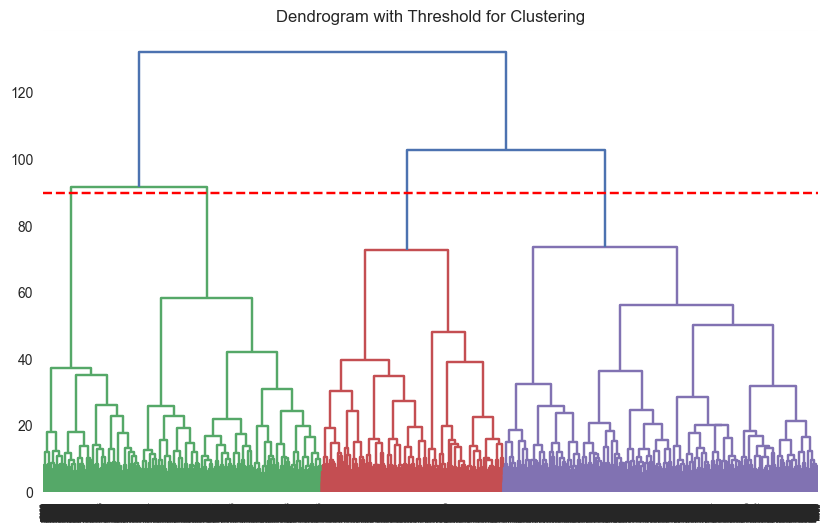

In [52]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

# Plot the Dendrogram with a threshold
plt.figure(figsize=(10, 6))
plt.title("Dendrogram with Threshold for Clustering")
dend = shc.dendrogram(shc.linkage(pca_90_result, method='ward'))
plt.axhline(y=90, color='r', linestyle='--')  # Adjust the y-value to focus on higher levels of clustering
plt.show()

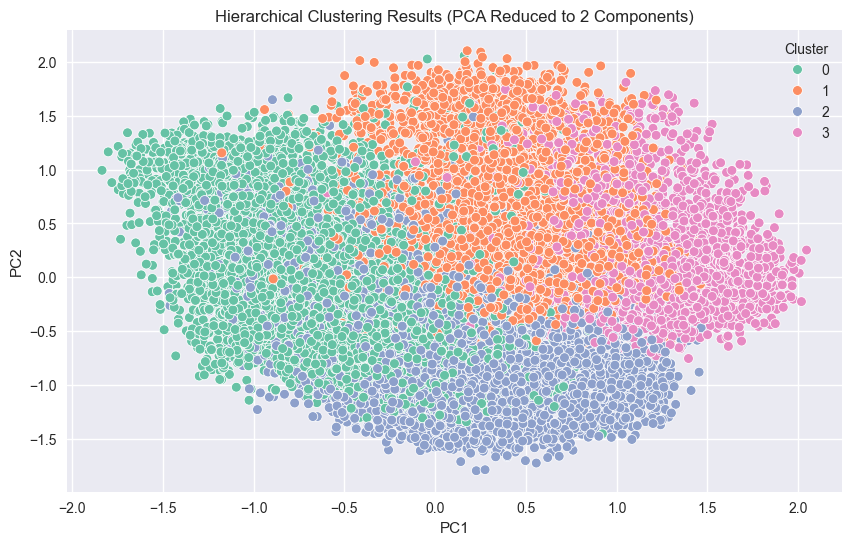

In [53]:
# Perform Hierarchical Clustering with 4 clusters
hierarchical = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(pca_90_result)  

# Visualize the clusters using the first two PCA components
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(pca_90_result)

# Create a dataframe for the 2D PCA results
pca_df = pd.DataFrame(data=pca_2_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = hierarchical_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2', s=50)
plt.title('Hierarchical Clustering Results (PCA Reduced to 2 Components)')
plt.show()

We begin by generating summary statistics for each cluster. This will give us an understanding of the average values, medians, and ranges of key features for each cluster.

In [54]:
# Generate summary statistics for each cluster (numerical columns only)
def get_cluster_summary(data, cluster_labels):
    data['Cluster'] = cluster_labels
    # Select only numerical columns
    numeric_data = data.select_dtypes(include=[np.number])
    summary = numeric_data.groupby('Cluster').agg(['mean', 'median', 'min', 'max'])
    return summary

# Apply to K-means clusters
kmeans_summary = get_cluster_summary(subset_df.copy(), kmeans_labels)
print(kmeans_summary)

# Apply to hierarchical clusters
hierarchical_summary = get_cluster_summary(subset_df.copy(), hierarchical_labels)
print(hierarchical_summary)

            DOEID                                   HDD65                      \
             mean    median       min       max      mean    median       min   
Cluster                                                                         
0        0.494157  0.483401  0.000487  0.999351  0.074878  0.068544  0.000000   
1        0.504206  0.507543  0.000054  1.000000  0.149305  0.158373  0.001898   
2        0.492378  0.491106  0.000000  0.999081  0.336634  0.312432  0.000058   
3        0.500631  0.499378  0.000216  0.999838  0.339092  0.332049  0.169188   

                      CDD65            ... LGTINCAN          SOLAR         \
              max      mean    median  ...      min  max      mean median   
Cluster                                ...                                  
0        0.261750  0.551935  0.481749  ...      0.0  1.0  0.124910    0.0   
1        0.330668  0.395308  0.325262  ...      0.0  1.0  0.022199    0.0   
2        1.000000  0.105857  0.089628  ...     

In [55]:
# Add cluster labels to the original (non-normalized, non-imputed) data
original_df = recs_df[cols_to_keep + cols_to_fix].drop(columns=cols_to_drop).copy()
original_df['Cluster'] = kmeans_labels


In [57]:
# Identify numerical columns
numeric_cols = original_df.select_dtypes(include=[np.number]).columns.tolist()

# For numerical features, compute mean values per cluster
cluster_summary = original_df.groupby('Cluster')[numeric_cols].mean()

print("Cluster Summary (Mean Values):")
print(cluster_summary)

Cluster Summary (Mean Values):
                 DOEID        HDD65        CDD65  HDD30YR_PUB  CDD30YR_PUB  \
Cluster                                                                      
0        109140.428884  1301.605580  3054.406455  1497.376915  2444.600109   
1        109326.287446  2595.367864  2187.636280  3058.689994  1982.081031   
2        109107.539779  5851.702105   585.813771  6052.770603   453.476275   
3        109260.175398  5894.443053   916.560893  6384.102599   758.260308   

         KOWNRENT  YEARMADERANGE  BEDROOMS  NCOMBATH  NHAFBATH  ...  \
Cluster                                                         ...   
0        1.343545       4.876368  2.848468  1.909737  0.268053  ...   
1        1.291130       5.022406  2.894414  1.902394  0.335789  ...   
2        1.274706       4.840171  2.964324  1.886907  0.326793  ...   
3        1.263029       3.922847  2.860797  1.682678  0.410396  ...   

         TEMPGONEAC  TEMPNITEAC   H2OMAIN  WHEATBKT  LGTINLED  LGTINCFL  

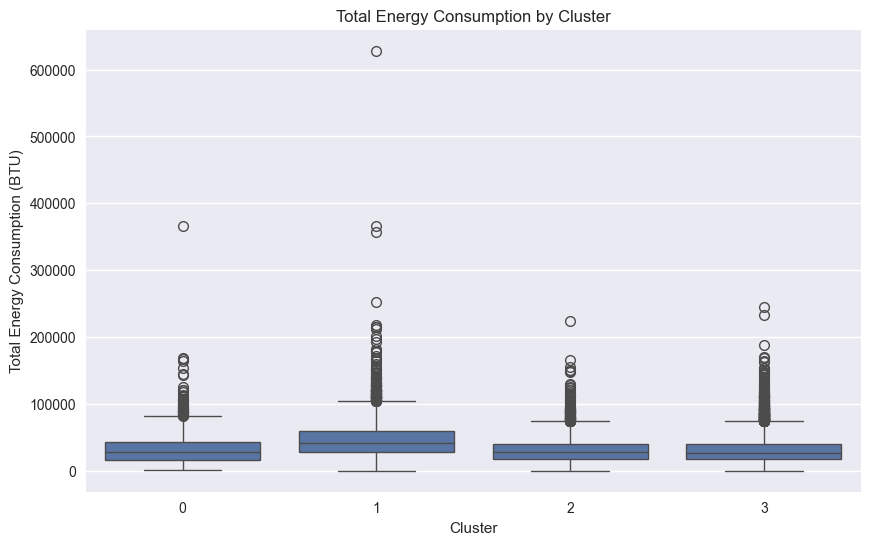

In [60]:
# Box plot for total energy consumption by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='BTUEL', data=original_df)
plt.title('Total Energy Consumption by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Energy Consumption (BTU)')
plt.show()


In [61]:
# For categorical features, compute mode per cluster
categorical_cols = original_df.select_dtypes(include=['object']).columns.tolist()

cluster_modes = original_df.groupby('Cluster')[categorical_cols].agg(lambda x: x.mode().iloc[0])

print("Most Common Categories per Cluster:")
print(cluster_modes)

Most Common Categories per Cluster:
           REGIONC state_postal   BA_climate UATYP10
Cluster                                             
0             WEST           CA      Hot-Dry       U
1            SOUTH           TX  Mixed-Humid       U
2             WEST           WA         Cold       U
3        NORTHEAST           NY         Cold       U
